# Setup

First, we import all the basic stuff that we need. You can find the code for `keras_utilities` [here](https://github.com/rforgione/keras-utilities). It's basically a compilation of the utility code written by Jeremy Howard for the FastAI deep learning course, and some of my own code for creating the appropriate directory structure for Keras models. 

In [1]:
from keras_utilities import *
from keras_utilities.models.vgg16bn import Vgg16BN
from keras_utilities.models.vgg16 import Vgg16
from keras.layers import Dense
import os
from numpy import array
from IPython.display import FileLink
from numpy.random import permutation
from keras.preprocessing import image

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 5103)
Using Theano backend.


## Control Panel

In [2]:
prod = True

if not prod:
    path = 'sample/'
else:
    path = 'data/'
    
batch_size = 64

model_dir = "models/"
results_dir = "results/"

The following three sequences are commented out, because we only want to run them one time. This first one takes 10% of the training data and copies it into a sample data directory. We can use this sample directory to quickly iterate on models.

In [3]:
# for subdir in ['c' + str(i) for i in range(10)]:
#     if not os.path.exists("sample/train/%s" % subdir):
#         os.makedirs("sample/train/%s" % subdir)
#     create_sample_data("data/train/%s" % subdir, "sample/train/%s" % subdir)

In this next piece, we take 25% of our training data and move it into a validation set directory.

In [4]:
# for subdir in ['c' + str(i) for i in range(10)]:
#     if not os.path.exists("data/valid/%s" % subdir):
#         os.makedirs("data/valid/%s" % subdir)
#     create_sample_data("data/train/%s" % subdir, "data/valid/%s" % subdir, 
#                        method="move", sample_pct=.25)

Finally, we take 25% of our sample data and move it into a sample validation set directory.

In [5]:
# for subdir in ['c' + str(i) for i in range(10)]:
#     if not os.path.exists("sample/valid/%s" % subdir):
#         os.makedirs("sample/valid/%s" % subdir)
#     create_sample_data("sample/train/%s" % subdir, "sample/valid/%s" % subdir, 
#                        method="move", sample_pct=.25)

Let's do a quick check on whether this worked:

In [6]:
# training data for class c0
!ls -1 data/train/c0 | wc -l

1949


In [7]:
# sample training data for class c0, should be about 10% of the data above
!ls -1 sample/train/c0 | wc -l

166


In [8]:
# validation data for class c0, should be about 1/3 of the training data for c0
!ls -1 data/valid/c0 | wc -l

540


In [9]:
# sample validation data for class c0, should be about 10% of the sample training data for c0
!ls -1 sample/valid/c0 | wc -l

62


So the percentages don't work out perfectly, but they're good enough for our purposes. We now have a pretty well organized collection of image data. Time to move onto the fun part: the actual modeling.

# Modeling

In [2]:
vgg = Vgg16()

In [3]:
vgg.ft(10)

In [40]:
batches = get_batches(path+"train", batch_size=64)
val_batches = get_batches(path+"valid", batch_size=64)

Found 16904 images belonging to 10 classes.
Found 5520 images belonging to 10 classes.


In [47]:
vgg.fit(batches=batches, val_batches=val_batches)

Epoch 1/1
16904/16904 [==============================] - 581s - loss: 2.0407 - acc: 0.4347 - val_loss: 0.6271 - val_acc: 0.8109


In [51]:
vgg.model.save_weights(model_dir+"vgg_ft_1epoch.h5")

In [43]:
vgg.model.load_weights(model_dir+"vgg_ft_1epoch.h5")

In [22]:
files = os.listdir("data/test/unknown/")

In [7]:
test_batches = get_batches("data/test/", batch_size=32)

Found 79726 images belonging to 1 classes.


In [96]:
batch = next(test_batches)

In [9]:
batch[0].shape

NameError: name 'batch' is not defined

In [8]:
preds = vgg.test("data/test", batch_size=32)

Found 79726 images belonging to 1 classes.


In [20]:
def create_prediction_file(filename, preds=None, model=None):
    if not preds:
        preds = model.test("data/test", batch_size=32)
    elif not model and not preds:
        raise ValueError("Must pass either preds or a model.")
        
    files = os.listdir("data/test/unknown/")
        
    pred_str = map(lambda x: ",".join(["%.10f" % i for i in x]), preds[1].tolist())
    rows = [",".join([a,b]) + "\n" for a,b in zip(files, pred_str)]
    with open(filename, "a") as f:
        f.write("img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9\n")
        for row in rows:
            f.write(row)

In [33]:
create_prediction_file(results_dir+"results_vgg.csv", preds=preds)

In [35]:
FileLink(results_dir+"results_vgg.csv")

/home/ubuntu/statefarm-kaggle/results/results_vgg.csv

In [36]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

Results: 1.42 (1.54 private) which gets the job done!

In [38]:
for layer in ['convolution2d_13', 'dense_1', 'dense_2', 'dense_4']:
#     if isinstance(layer, Dense):
    vgg.model.get_layer(layer).trainable = True
        
vgg.compile()

In [49]:
vgg.fit(batches=batches, val_batches=val_batches)

In [46]:
vgg16bn = Vgg16BN()
vgg16bn.ft(10)
vgg16bn.compile()
vgg16bn.fit(batches=batches, val_batches=val_batches)

Epoch 1/1
16904/16904 [==============================] - 530s - loss: 2.0009 - acc: 0.5790 - val_loss: 0.3120 - val_acc: 0.9082


In [52]:
vgg16bn.model.save_weights(model_dir+"vgg16bn_1_epoch_and_change.h5")

In [53]:
vgg16bn.fit(batches=batches, val_batches=val_batches)

Epoch 1/1
16904/16904 [==============================] - 528s - loss: 0.9828 - acc: 0.7735 - val_loss: 0.1888 - val_acc: 0.9442


In [47]:
create_prediction_file(results_dir+"vggbn_results.csv", model=vgg16bn)

Found 79726 images belonging to 1 classes.


In [48]:
FileLink(results_dir+"vggbn_results.csv")

/home/ubuntu/statefarm-kaggle/results/vggbn_results.csv

## Creating a val set according to driver.

In [11]:
import pandas as pd
import shutil
imgs_list = pd.read_csv("data/driver_imgs_list.csv")

imgs_list['subject'].nunique()

imgs_list['file_path'] = imgs_list.apply(lambda x: "/".join([x['classname'], x['img']]), axis=1)

train_subjects = list(imgs_list['subject'].unique()[:20])
valid_subjects = list(imgs_list['subject'].unique()[20:])

val_imgs = list(imgs_list.loc[imgs_list['subject'].isin(valid_subjects), 'file_path'])

train_dir = "data/train/"
val_dir = "data/valid/"

for img in val_imgs:
    shutil.move(train_dir+img, val_dir+img)

NameError: name 'val_imgs' is not defined

In [14]:
batch_size=64

batches = get_batches(train_dir, batch_size=batch_size)
val_batches = get_batches(val_dir, batch_size=batch_size*2)

Found 17778 images belonging to 10 classes.
Found 4646 images belonging to 10 classes.


In [99]:
vgg16bn = Vgg16BN()
vgg16bn.ft(10)
vgg16bn.fit(batches, val_batches)

Epoch 1/1
17778/17778 [==============================] - 513s - loss: 1.6727 - acc: 0.6478 - val_loss: 3.5778 - val_acc: 0.3928


In [220]:
vgg16 = Vgg16()
vgg16.ft(10)
vgg16.fit(batches, val_batches)

Epoch 1/1
17778/17778 [==============================] - 510s - loss: 1.8582 - acc: 0.4787 - val_loss: 2.6045 - val_acc: 0.3061


In [240]:
preds = vgg16.model.predict_generator(val_batches, val_batches.nb_sample)

In [244]:
pred_clss = np.argmax(preds, axis=1)

In [245]:
pred_clss

array([7, 4, 6, ..., 3, 2, 7])

In [252]:
true_clss = val_batches.classes

In [253]:
true_clss

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [256]:
idx = np.where(pred_clss == true_clss)[0]

In [224]:
example_batch = next(batches)

In [239]:
vgg16.model.predict_proba(list(val_batches))

KeyboardInterrupt: 

In [109]:
import numpy as np
correct = np.where(preds == val_labels[:,1])[0]

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  


In [110]:
correct

array([], dtype=int64)

In [132]:
for i in range(100):  
    val_data = next(val_batches)
    
pred = vgg.model.predict(val_data[0], batch_size=batch_size)

In [134]:
val_data = next(val_batches)[0]

In [138]:
val_classes = val_batches.classes
val_labels = onehot(val_classes)

In [218]:
preds = vgg.model.predict_classes(val_data)

128/128 [==============================] - 3s     


In [170]:
def plots_idx(idx, titles=None):
    plots([image.load_img(path + "valid/" + filenames[i]) for i in idx], titles=titles)

In [176]:
# get examples where we were right
idx = np.where(val_labels == val_preds)[0]

In [177]:
idx_permutation = permutation(idx)[:5]

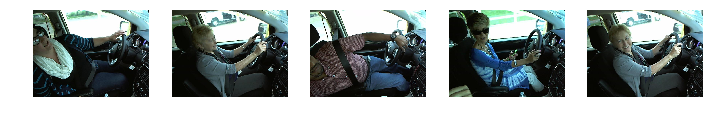

In [179]:
from keras.preprocessing import image
%matplotlib inline
filenames = val_batches.filenames
plots_idx(idx_permutation)

In [189]:
val_preds.shape

(4646, 10)

In [190]:
val_labels.shape

(4646, 10)

In [206]:
val_pred_class = np.argmax(val_preds, axis=1)

In [207]:
val_true_class = np.argmax(val_labels, axis=1)

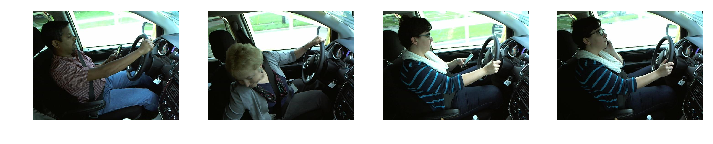

In [257]:
correct = np.where(pred_clss == true_clss)[0]
idx = permutation(correct)
plots_idx(idx[:4])

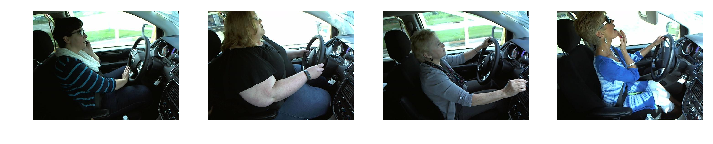

In [262]:
incorrect = np.where(pred_clss != true_clss)[0]
idx = permutation(incorrect)
plots_idx(idx[:4])

In [263]:
??vgg.get_batches

In [7]:
gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
       channel_shift_range=10., dim_ordering='th')

In [8]:
batches_aug = get_batches("data/train", gen=gen, batch_size=32)

Found 17778 images belonging to 10 classes.


In [15]:
vgg_aug = Vgg16()
vgg_aug.ft(10)
vgg_aug.fit(batches=batches_aug, val_batches=val_batches)

Epoch 1/1
17778/17778 [==============================] - 514s - loss: 2.2270 - acc: 0.4079 - val_loss: 2.3061 - val_acc: 0.3330


In [21]:
create_prediction_file(filename="vgg_aug_results.csv", model=vgg_aug)

Found 79726 images belonging to 1 classes.


In [22]:
FileLink("vgg_aug_results.csv")

/home/ubuntu/statefarm-kaggle/vgg_aug_results.csv